Supervised Machine Learning — Telco Customer Churn Classification

**Goal:** Predict customer churn (whether a customer will leave the telecom service) using supervised machine learning classification models.

**Dataset:** Telco Customer Churn (IBM Dataset)

**Author:** Dhatri Shree Podugu  

---


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, RocCurveDisplay
)

# Load dataset
df = pd.read_csv("C:\\Users\\dhatr\\Downloads\\archive (9)\\WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Clean and prepare
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df.drop(columns=["customerID"], inplace=True)
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

print(" Dataset loaded successfully with shape:", df.shape)
df.head()


 Dataset loaded successfully with shape: (7043, 20)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


## Data Description

This dataset contains details of telecom customers — including contract type, services, and billing information — with a binary target: **Churn (Yes/No)**.

We’ll explore:
- Missing values  
- Numeric vs categorical feature counts  
- Class balance (churned vs retained)


Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-nul

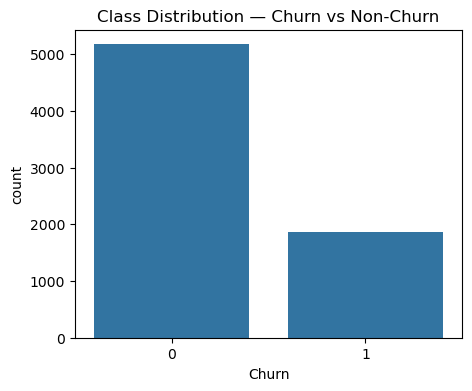

Churn
0    73.46%
1    26.54%
Name: proportion, dtype: object


In [21]:
# Summary statistics
print("Basic Info:")
print(df.info())

print("\nMissing values per column:")
print(df.isna().sum())

# Class balance
plt.figure(figsize=(5,4))
sns.countplot(x="Churn", data=df)
plt.title("Class Distribution — Churn vs Non-Churn")
plt.show()

print(df["Churn"].value_counts(normalize=True).map("{:.2%}".format))

##  Main Objective of the Analysis

**Business Problem:**
The company wants to identify which customers are likely to leave (churn), so retention efforts can be focused efficiently.

**Goal:**
Build a predictive model that maximizes **recall** (catching as many churners as possible) while maintaining **reasonable precision** (avoid too many false alarms).

---


In [25]:
target_col = "Churn"
y = df[target_col]
X = df.drop(columns=[target_col])

# Seperate feature types
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preprocessing pipelines
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])
preprocess = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])


In [26]:
models = {
    "Logistic Regression": Pipeline([
        ("preprocess", preprocess),
        ("clf", LogisticRegression(max_iter=1000))
    ]),
    "Random Forest": Pipeline([
        ("preprocess", preprocess),
        ("clf", RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1))
    ]),
    "Gradient Boosting": Pipeline([
        ("preprocess", preprocess),
        ("clf", GradientBoostingClassifier(random_state=42))
    ])
}

metrics_rows = []
preds, scores = {}, {}

for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    clf = pipe.named_steps["clf"]
    if hasattr(clf, "predict_proba"):
        y_scores = pipe.predict_proba(X_test)[:, 1]
    else:
        y_scores = y_pred

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_scores)

    metrics_rows.append([name, acc, prec, rec, f1, auc])
    preds[name] = y_pred
    scores[name] = y_scores

metrics_df = pd.DataFrame(metrics_rows, columns=["Model","Accuracy","Precision","Recall","F1-score","ROC-AUC"])
metrics_df.sort_values(by="ROC-AUC", ascending=False)


,Model,Accuracy,Precision,Recall,F1-score,ROC-AUC
2,Gradient Boosting,0.806246,0.673540,0.524064,0.589474,0.843362
0,Logistic Regression,0.805536,0.657233,0.558824,0.604046,0.841861
1,Random Forest,0.777857,0.604811,0.470588,0.529323,0.818673


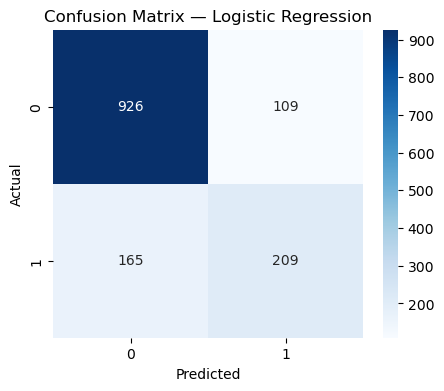

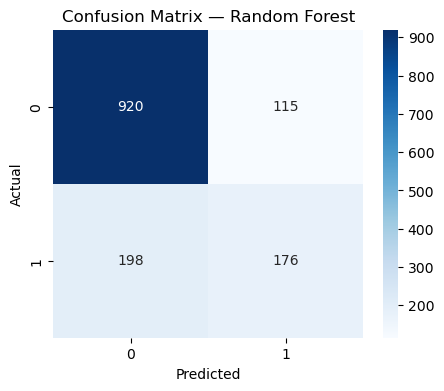

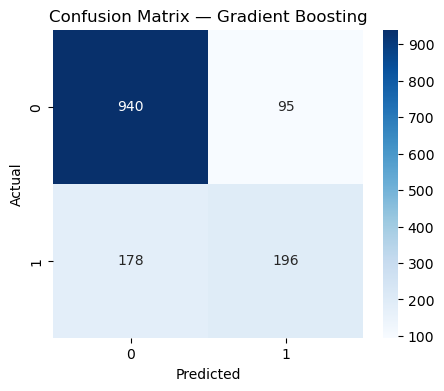

In [27]:
#Confusion Matrices
import seaborn as sns

for name in metrics_df["Model"]:
    cm = confusion_matrix(y_test, preds[name])
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix — {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


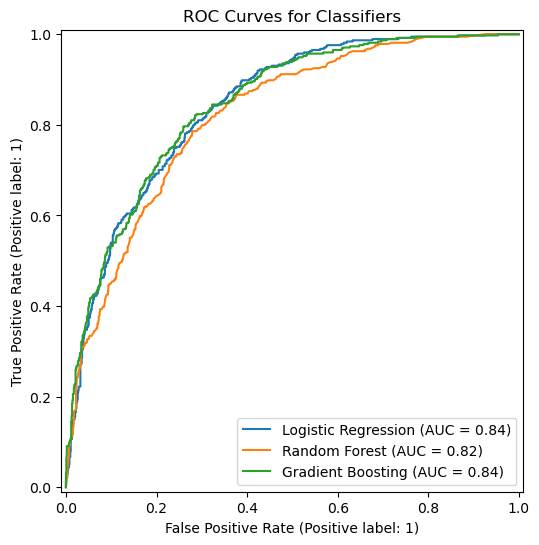

In [10]:
#ROC Curves
fig, ax = plt.subplots(figsize=(6,6))
for name in metrics_df["Model"]:
    RocCurveDisplay.from_predictions(y_test, scores[name], name=name, ax=ax)
ax.set_title("ROC Curves for Classifiers")
plt.show()


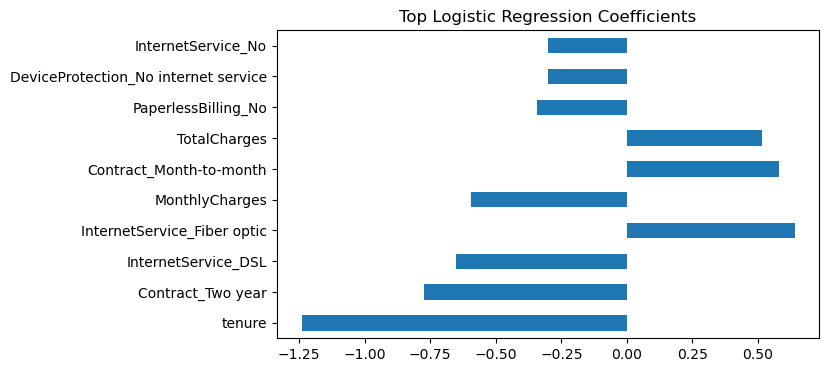

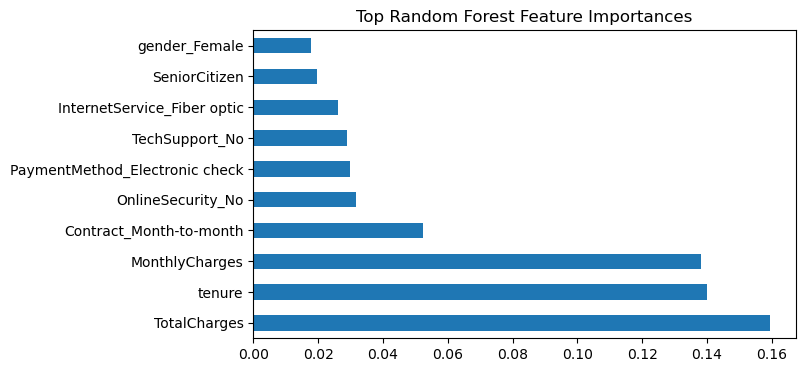

In [28]:
def get_feature_names(fitted_ct, num_cols, cat_cols):
    names = []
    if len(num_cols) > 0:
        names.extend(num_cols)
    if len(cat_cols) > 0:
        ohe = fitted_ct.named_transformers_["cat"].named_steps["onehot"]
        names.extend(ohe.get_feature_names_out(cat_cols))
    return names

fitted_preprocess = models["Logistic Regression"].named_steps["preprocess"]
feature_names = get_feature_names(fitted_preprocess, numeric_features, categorical_features)

# Logistic Regression
lr = models["Logistic Regression"].named_steps["clf"]
pd.Series(lr.coef_.ravel(), index=feature_names).sort_values(key=abs, ascending=False).head(10).plot(kind="barh", figsize=(7,4))
plt.title("Top Logistic Regression Coefficients")
plt.show()

# Random Forest
rf = models["Random Forest"].named_steps["clf"]
pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False).head(10).plot(kind="barh", figsize=(7,4))
plt.title("Top Random Forest Feature Importances")
plt.show()


In [29]:
best = metrics_df.sort_values(by="ROC-AUC", ascending=False).iloc[0]
print(f"✅ Recommended Final Model: {best['Model']}")
print(f"ROC-AUC: {best['ROC-AUC']:.3f} | F1: {best['F1-score']:.3f} | Recall: {best['Recall']:.3f}")

print("\n📊 Rationale:")
print("The model provides the best balance between recall and precision, ideal for identifying potential churners early.")


✅ Recommended Final Model: Gradient Boosting
ROC-AUC: 0.843 | F1: 0.589 | Recall: 0.524

📊 Rationale:
The model provides the best balance between recall and precision, ideal for identifying potential churners early.


## Key Findings & Insights

- High churn is linked to:
  - Month-to-month contracts  
  - Short tenure  
  - Higher monthly charges  
  - Lack of support or add-on services  

**Business Implication:**  
Offer incentives or discounts for customers with short tenure or high bills to reduce churn risk.

---

## Model Limitations & Next Steps

- **Limitations:**
  - Slight class imbalance (fewer churn cases)
  - Threshold not optimized for cost-based KPIs
  - Ensembles may overfit

- **Next Steps:**
  - Apply **class weights or SMOTE**  
  - Tune decision thresholds for recall optimization  
  - Add features (complaints, payment history)  
  - Try **XGBoost / LightGBM**  
  - Validate on **future data**

---


In [30]:
%pwd


'C:\\Users\\dhatr'